### Set up notebook dependencies

In addition to the Gensim library, this notebook makes use of Ray Tune for hyperparameter optimization. These and a few other dependencies are installed in the following cell. Installation can take several minutes so we recommend starting now while you dig into the notebook intro. 

In [2]:
%%capture
# ^ hiding large cell output. disable for logs.
!pip3 install -r requirements.txt
!pip3 install ray[tune]

# Learning item embeddings with Gensim's Word2Vec



Popularized by word vector representations, "embeddings" have become a staple of modern machine learning -- and they're not just for words anymore! It's become common to learn embeddings for all kinds of things: retail products, hotel listings, user profiles, videos, music, and more.  Just about anything can be represented as a numerical vector. 

**Why item embeddings?**

A learned embedding is a numerical vector representation for some object (a product, a video, a word) in a _latent space,_ a space in which similar objects have vectors that are closer together. This property makes embeddings useful for a slew of downstream tasks such as recommendation, classification, clustering, and more. 

**Why Word2Vec?**

The now canonical Word2Vec spawned an army of similar algorithms; some of our favorites include [Doc2Vec](https://arxiv.org/abs/1405.4053), [Prod2Vec](https://arxiv.org/abs/1606.07154), [code2vec](https://arxiv.org/abs/1803.09473), and [node2vec](https://arxiv.org/abs/1607.00653). While many of these algorithms were inspired by the original, they include layers of sophistication and domain adaptations tailored to specific use cases or data types. While the array of "2vec" algorithms may seem daunting (how do we know which one is best for our use case?), it never hurts to start with a classic. Not only has Word2Vec been shown to be [competitive](https://arxiv.org/pdf/1804.04212.pdf) with some of these more tailored approaches, it also provides a strong baseline for comparison. And with the [Gensim](https://radimrehurek.com/gensim/index.html) library, training Word2Vec is fast, lightweight, and production-ready. 

**Prereqs**

Perhaps the best feature of all is that Word2Vec is an unsupervised algorithm, so you won't need labeled data. However, you _will_ need data structured in such a way that it mimics a _corpus_: a collection of documents or sentences, themselves collections of words. If your data naturally lends itself to being grouped into meaningful sets or sequences, read on! 


**Notebook Goals**

The goal of this notebook is to demonstrate how to use the classic Word2Vec algorithm from the Gensim library to learn *thing*2vec embeddings.  While we hope to demonstrate a broad application, we'll need a specific dataset for demonstration. To that end, we'll make use of our recent explorations on [Session Based Recommenders](https://session-based-recommenders.fastforwardlabs.com/) in which we learned product embeddings for an online retail store by considering customer transactions. These embeddings were then used to recommend products that a customer might be interested in. Details on our approach can be found in the accompanying [report](https://session-based-recommenders.fastforwardlabs.com/). This AMP highlights the technical aspects of Gensim training while glossing over many of the details of session-based recommender systems, which we cover in the previously cited materials. 

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [19]:
import os
from copy import deepcopy 
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import umap

from gensim.models.word2vec import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
from ray import tune
from ray.tune.schedulers import ASHAScheduler

## The data 

For this demonstration we'll use the Online Retail dataset downloaded form the UCI Machine Learning Repository. We explored this dataset in depth for our Session-based recommenders project and detailed our findings in this [notebook](https://github.com/fastforwardlabs/session_based_recommenders/blob/2dde9a7265fd3a7e3bed567cd14dd412b7a5c708/notebooks/Explore_Online_Retail_Dataset.ipynb). Here we'll provide a quick recap.  

The Online Retail dataset contains purchase transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based online retail store. The company mainly sells unique all-occasion gifts. The most important columns in the dataset are:

* **StockCode**: unique ID for each product
* **Description**: product name in plain text 
* **CustomerID**: unique customer ID 

In [4]:
df = pd.read_csv("data/ecomm/OnlineRetail.csv")

In [5]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


Our goal is to learn embeddings for each product in our dataset. To do that, we'll learn embeddings for each `StockCode` because they are unique identifiers for each product.  We _could_ create a corpus with one giant sentence by feeding in the entire column of `StockCodes` to Word2Vec, but better results will be achieved if we can supply meaningful structure. Word2Vec learns meaning according to how often tokens co-occur in a sequence, thus word embeddings have meaning because sentences and paragraphs are meaningful ways to structure language. 

We can realize meaningful structure by grouping our `StockCodes` by `CustomerID`. This yields a sequence of purchases made over time by each customer in the dataset. The meaning of the sequence is clear: it's simply the items that a customer chooses to purchase at various points in time. 

In our Session-based Recommenders report we describe this as a customer's _session_ -- a sequence of products a customer purchased over a period of time. 

--- 
**Aside**: Why not use pre-trained _word_ embeddings on the product descriptions? Honestly, that's a valid approach! But our goal is to showcase how to learn _non-word_ embeddings. Furthermore, there is no reason to believe that these two types of embeddings will be encapsulate the same information. 

---


Below is a one such customer session (you can see their full session by removing the `head` modifier):

In [6]:
customer_groups = df.groupby("CustomerID")
pd.DataFrame(list(customer_groups)[2][1])[["StockCode", "Description"]].head(5)

,StockCode,Description
34083,84992,72 SWEETHEART FAIRY CAKE CASES
34084,22951,60 CAKE CASES DOLLY GIRL DESIGN
34085,84991,60 TEATIME FAIRY CAKE CASES
34086,84991,60 TEATIME FAIRY CAKE CASES
34087,21213,PACK OF 72 SKULL CAKE CASES


The `StockCode` column provides a sequence of product IDs that we will treat as a sentence. Each unique customer yields a different "sentence" and the collection of all customer sessions will act as our corpus. The function below reformats our original dataframe into one palatable by Gensim. 

In [20]:
def preprocess_ecomm(df, min_session_count=3):
    """
    preprocessing includes three steps:
    1. drop nans
    2. exclude sessions shorter than min_session_count
    3. group sessions by CustomerID
    """
    df.dropna(inplace=True)
    # exclude sessions shorter than min_session_count
    item_counts = df.groupby(["CustomerID"]).count()["StockCode"]
    df = df[
        df["CustomerID"].isin(item_counts[item_counts >= min_session_count].index)
    ].reset_index(drop=True)
    # group sessions by CustomerID
    grp_by_session = df.groupby(["CustomerID"])
    session_sequences = []
    for name, group in grp_by_session:
        session_sequences.append(list(group["StockCode"].values))
    # Save sequences
    pickle.dump(session_sequences, open("data/ecomm/OnlineRetail_sessions.pkl", "wb"))
    return session_sequences
    
corpus = preprocess_ecomm(df)

Here's that same customer, now in a format that Gensim's word2vec model can parse. There are 4234 "sentences" in our product corpus. 

In [8]:
print(*corpus[1])

84992 22951 84991 84991 21213 21213 22616 21981 21982 21725 21211 84988 22952 22952 21977 21977 POST 21980 21985 21726 21983 21967 POST 23077 23078 23076 22437 POST 23077 23078 POST


Next we'll split our data into the usual train, test, and validation sets.

In [9]:
def train_test_split(session_sequences, test_size: int = 10000):
    """
    Train set is constructed from the first n-1 items in a session sequence of n items. 
    Test set is constructed of (n-1, n) "query" pairs where the n-1 item is used to generate 
    recommendation predictions and it is checked whether the nth item is included in those recommendations. 

    Example:
        Given the sequence ['045', '334', '342', '8970', '128']
        Train set includes ['045', '334', '342', '8970'] while
        Test (validation) set would be ['8970', '128']
    
    Test and Validation sets are constructed to be disjoint. 
    """
    rng = np.random.default_rng(123)

    ### Construct training set
    # use (1 st, ..., n-1 th) items from each session sequence as train set (i.e., exclude last item)
    train = [sess[:-1] for sess in session_sequences]

    if test_size > len(train):
        print(
            f"Test set cannot be larger than train set. Train set contains {len(train)} sessions."
        )
        return

    ### Construct test and validation sets
    # sub-sample 10k sessions, and use (n-1 th, n th) pairs of items from session_squences to form 
    # disjoint validaton and test sets
    test_validation = [sess[-2:] for sess in session_sequences]
    index = rng.choice(range(len(test_validation)), test_size * 2, replace=False)
    test = np.array(test_validation)[index[:test_size]].tolist()
    validation = np.array(test_validation)[index[test_size:]].tolist()
    return train, test, validation

train, test, valid = train_test_split(corpus, test_size=1000)

## Setting up training

If you take a gander at the Gensim documentation, training word2vec embeddings on your corpus is a single line of code!

In [41]:
# this automatically trains word2vec on a corpus and returns a model that contains the embeddings 
out_of_the_box_model = Word2Vec(sentences=train) 


So what more do we need? Turns out, a few things. The above line of code will train word2vec using the default hyperparameters, which have empirically been deemed appropriate for  human language. However, we are not learning embeddings for words in sentences -- we're learning item embeddings from a sequence of purchases! As such, there's no reason to believe that the default hyperparameters will be sufficient for our use case. This means we'll need to perform a hyperparameter search. 


### Ingredients for hyperparameter optimization (HPO)
While integral to the machine learning lifecycle, hyperparameter optimization is a computationally demanding task. In order to manage and minimize the computational cost, we'll need some help from the [Ray Tune](https://docs.ray.io/en/master/tune/index.html), a Python library for experiment execution and hyperparameter tuning at any scale. Specifically, we'll make use of an early stopping algorithm ([ASHA](https://arxiv.org/abs/1810.05934)) that terminates trials of hyperparameter configurations that are underperforming, thus saving compute time in favor of configurations that are more promising. 


ASHA (and other early stopping HPO algorithms) work by monitoring a metric during training for each hyperparameter configuration, comparing them, and terminating those that underperform. This means we need a metric to monitor throughout training. Enter Gensim Callbacks. 


### Logging metrics during training with Gensim Callbacks

A loss logger is standard fair but it turns out that Gensim's loss logging for the word2vec model is a little buggy (see [this](https://github.com/RaRe-Technologies/gensim/pull/2135) GitHub issue). While it provides a basis for drawing general conclusions about the overall health of your training (e.g., loss should generally be decreasing), the actual values are not super useful. 

More importantly, monitoring the model's training loss doesn't measure the quality of our item embeddings (see our related [blog post](https://blog.fastforwardlabs.com/2021/09/20/how-and-when-to-enable-early-stopping-for-gensims-word2vec.html) for more on why). For that, we need to consider a metric that measures a downstream task we're interested in. For example, since we're trying to learn item embeddings, we might be interested in how successful these embeddings are at providing recommendations. There are tons of metrics that measure recommendation quality. We'll use Recall@K. 

Because downstream metrics evaluate the quality of the *embeddings* (rather than the whole model), they must be computed using the model's learned embeddings _up to that point in the training,_ as applied to a validation set.  This requires a bit of finaggling (see lines 17 and 18).

In [10]:
class RecallAtKLogger(CallbackAny2Vec):
    '''Report Recall@K metric at end of each epoch
    
    Computes and reports Recall@K on a validation set with
    a given value of k (number of recommendations to generate). 
    '''
    def __init__(self, validation, k=10, ray=False):
        self.epoch = 0
        self.validation = validation
        self.k = k
        self.ray = ray

    def on_epoch_end(self, model):
        # make deepcopy of the model and emulate training completion
        mod = deepcopy(model)
        mod._clear_post_train() 
        
        # compute recall@k on the validation set
        # using the model's embedding vectors
        score = 0
        for query_item, ground_truth in self.validation:
            try:
                # get the k most similar items to the query item
                neighbors = mod.wv.most_similar(query_item, topn=self.k)
            except KeyError:
                pass
            else:
                recommendations = [item for item, distance in neighbors]
                if ground_truth in recommendations:
                    score += 1
        score /= len(self.validation)        
        
        if self.ray:
            tune.report(recall_at_k = score) 
        else:
            print(f"Epoch {self.epoch} -- Recall@{self.k}: {score}")
        self.epoch += 1

Ray Tune requires a wrapper of it's own to execute for each hyperparameter configuration it attempts. This wrapper should contain everything necessary to train and evaluate the model: 
* data loading
* metric logging
* model training

In [11]:
def tune_w2v(hyperparameters:dict):
    """ Hyperparameter optimization wrapper for Ray Tune"""
    ratk_logger = RecallAtKLogger(valid, k=10, ray=True)
    model = Word2Vec(sentences=train, callbacks=[ratk_logger], **hyperparameters)

## Hyperparameter optimization and early stopping with Ray Tune

Now we come to the good stuff! Here we define the hyperparameter search space. The Word2Vec model has many tunable hyperparameters. We select a subset here and perform a random search (learn more about the power of random search for HPO in this recent [blog post](https://blog.fastforwardlabs.com/2021/07/07/exploring-multi-objective-hyperparameter-optimization.html)). We also define a trial scheduler which will terminate trials with underperforming hyperparameter configurations. 

In [14]:
# NOTE: This cell takes approx 10-15 minutes to run depending on the number of available CPUs 

search_space = {
    "vector_size":  tune.randint(10, 100),
    "window":       tune.randint(3, 25),
    "ns_exponent":  tune.quniform(-1.0, 1.0, .2),
    "alpha":        tune.loguniform(1e-4, 1e-2),
    "negative":     tune.randint(1, 25),
    "epochs": 50,    
    "min_count": 1, # number of instances that a token appears before word2vec creates an embedding vector for it
    "workers": 6,   # number of CPU workers
    "sg": 1,        # trains the skip-gram version of word2vec
}

asha_scheduler = ASHAScheduler(max_t=100, grace_period=10) 

analysis = tune.run(
    tune_w2v,
    local_dir=os.path.abspath("ray_results"), # HPO trial results saved in this directory
    metric="recall_at_k",
    mode="max",
    scheduler=asha_scheduler,
    verbose=1,
    resources_per_trial={"cpu": 1}, # allot each trial 1 CPU (gensim will further allocate additional workers)
    num_samples=15,       # number of HP trials to attempt
    config=search_space,
)

2021-10-12 19:51:58,210	INFO tune.py:450 -- Total run time: 935.06 seconds (931.03 seconds for the tuning loop).


### Visualize HPO trials
Below we can examine the results of our hyperparameter optimization experiment. We plot the metric as a function of epochs for every attempted trial. Notice that many trials are terminated early because they clearly were performing worse than a few others, which dominated the metric throughout training. Only two hyperparameter configurations completed all 50 epochs of training, saving us a ton of compute time! 

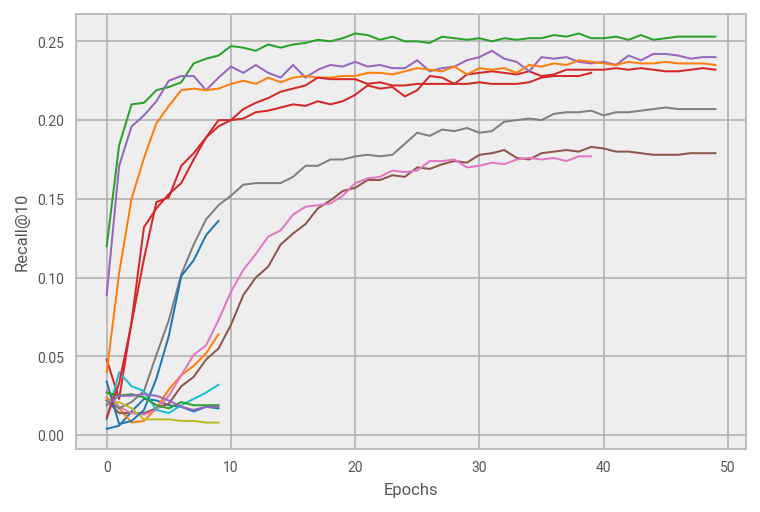

In [16]:
# Plot all trials as a function of epochs
dfs = analysis.trial_dataframes
ax = None
for d in dfs.values():
    ax = d.recall_at_k.plot(ax=ax)
ax.set_xlabel("Epochs");
ax.set_ylabel("Recall@10");


This process has produced a winning set of hyperparameters that we can now use to learn the best item embeddings for our dataset. Unless you set the `save_model = True` flag, we now need to train the winning model! (Ray Tune supports checkpointing and model saving but we have not implemented those features here). 

In [24]:
best_hps = analysis.get_best_config()
best_hps

{'alpha': 0.004077533869688067,
 'epochs': 50,
 'min_count': 1,
 'negative': 22,
 'ns_exponent': 0.8,
 'sg': 1,
 'vector_size': 33,
 'window': 7,
 'workers': 6}

In [25]:
tuned_model = Word2Vec(sentences=train, **best_hps)

## Evaluating Embeddings

Now that we have a trained model we can grab the embeddings, stored as a `KeyedVector` [object](https://radimrehurek.com/gensim/models/keyedvectors.html). These embeddings can be used for any downstream task, like generating recommendations as we discussed in our Session-based Recommender Systems report.

In [26]:
tuned_embeddings = tuned_model.wv # wv is short for word vectors
print(tuned_embeddings)

### Qualitative 

It can be challenging to validate the quality of learned embeddings. The best way is to evaluate on a downstream task (which we'll do next). But we can also examine the quality ... qualitatively. Here we pull up the description associated with one of our product IDs. 

In [27]:
productID = '84992'

df[df.StockCode == productID].Description.values[0]

'72 SWEETHEART FAIRY CAKE CASES'

Let's see which products are most similar to this one based on the embeddings we learned!

In [28]:
for productID, distance in tuned_embeddings.most_similar(productID):
    print(df[df.StockCode == productID].Description.values[0])

60 TEATIME FAIRY CAKE CASES
PACK OF 60 PINK PAISLEY CAKE CASES
PACK OF 60 DINOSAUR CAKE CASES
PACK OF 72 RETROSPOT CAKE CASES
PACK OF 60 MUSHROOM CAKE CASES
PACK OF 72 SKULL CAKE CASES
PACK OF 60 SPACEBOY CAKE CASES
IVORY PAPER CUP CAKE CASES 
60 CAKE CASES DOLLY GIRL DESIGN
75 GREEN FAIRY CAKE CASES


All of these products appear to be other types of "cake cases" or other baking items. Seems pretty reasonable!

Let's look at this on a larger scale by _embedding_ our embeddings into an even lower-dimensional space with UMAP. We'll then pair up our embeddings with some of the original information we have in our dataset, including the product description and the frequency with which that product is purchased. 

In [29]:
reducer = umap.UMAP()
reduced_embeddings = reducer.fit_transform(tuned_embeddings.vectors)

In [30]:
product_info = {}
for name, value in df[['StockCode', 'Description']].groupby('StockCode'):
    product_info[name] = [value.Description.values[0], len(value.Description.values)]

In [31]:
emb_df = pd.DataFrame({'x':reduced_embeddings[:,0], 'y':reduced_embeddings[:, 1], 
                       'Description':[product_info[stockcode][0] for stockcode in tuned_embeddings.index_to_key], 
                       'Frequency':[np.log10(product_info[stockcode][1]) for stockcode in tuned_embeddings.index_to_key]})

In [37]:
fig = px.scatter(emb_df, x='x', y='y', 
                 hover_name='Description', 
                 color='Frequency',
                 width=900, 
                 height=700, 
                 title="UMAP projection of learned Word2Vec product embeddings"
                )
fig.show()

In the figure above we plot the embeddings of all 3684 products in our dataset and color them according to how frequently they were purchased. The frequency is on a log scale so lighter colors indicate items that are purchased 1000x more often than those that are very dark purple. 

Empirically, it seems that items that are purchased less often (dark purple) are clumped in the middle without much clustering or separation (with the notable exception of the "Jewelry Arm" sticking up and to the right). While we caution against making snap judgements, it might be reasonable to assume that products that are purchased more often would have stronger (more predictive) embeddings because they show up more often during training. Word2Vec sees them more often and is better able to glean relationships between them. Better embeddings could then allow for better grouping and clustering. 

Hover over and zoom in to various areas on the chart and see if you find some interesting groupings! 

### Quantitative

During hyperparameter optimzation, we evaluated the embeddings-in-progress on a downstream task in order to identify and terminate underperforming models. We can now evaluate our test set on on this downstream task as a way to quantitatively assess the quality of our learned product embeddings. 

Let's understand the task a bit better before we dive in. We'll simulate a recommendation task with this dataset by using the embedding of the second to last item each customer purchased to generate ten similar items as recommendations. We'll then check whether this list of recommendations contains the item the customer _actually_ purchased last.  More details about this recommendation task can be found in the [Experiment section](https://session-based-recommenders.fastforwardlabs.com/#setup) of the Session-based Recommendation Systems report. 

The following two helper functions will generate and evaluate a list of recommendations given a product ID and a set of vector embeddings (as a `KeyedVector` object). 

In [38]:
def generate_recommendations(itemID, embedding_model, num_recs):
    """ Generate recommendations based on and itemID. 
    
    Recommendations are generated by pulling the num_recs items most similar 
    to itemID using the `most_similar` KeyedVector method which uses cosine similarity
    between embedding vectors
    """
    try:
        most_similar_products = embedding_model.most_similar(itemID, topn=num_recs)
    except KeyError:
        recommendations = []
    else:
        recommendations = [productID for productID, distance in most_similar_products]
    return recommendations

def evaluate_recommendations(recommendations, ground_truth):
    """ Evaluate a list of recommendations given a ground truth item. 
    
    If the ground_truth item is contained within the list of recommendations, score 1, else 0
    """
    if ground_truth in recommendations:
        return 1
    return 0

Now we'll loop through each customer in our test set, generate recommendations and score either 1 or 0 if our recommendations contained a match. We'll then divide by the number of customers in our dataset yielding what proportion of our recommendation lists were successful. 

In [39]:
tuned_score = 0
for last_seen_item, ground_truth_item in test:
    recs = generate_recommendations(last_seen_item, tuned_embeddings, 10)
    tuned_score += evaluate_recommendations(recs, ground_truth_item)
tuned_score /= len(valid)

print(tuned_score)

0.25


About 25%. That may not seem impressive but it turns out that this is a challenging task. And to drill that point home, let's see how well the out-of-the-box model's embeddings perform at the same task. 

In [42]:
ootb_embeddings = out_of_the_box_model.wv

ootb_score = 0
for last_seen_item, ground_truth_item in test:
    recs = generate_recommendations(last_seen_item, ootb_embeddings, 10)
    ootb_score += evaluate_recommendations(recs, ground_truth_item)
ootb_score /= len(valid)

print(ootb_score)

0.209


See? Much worse! Let's make a pretty figure for it. 

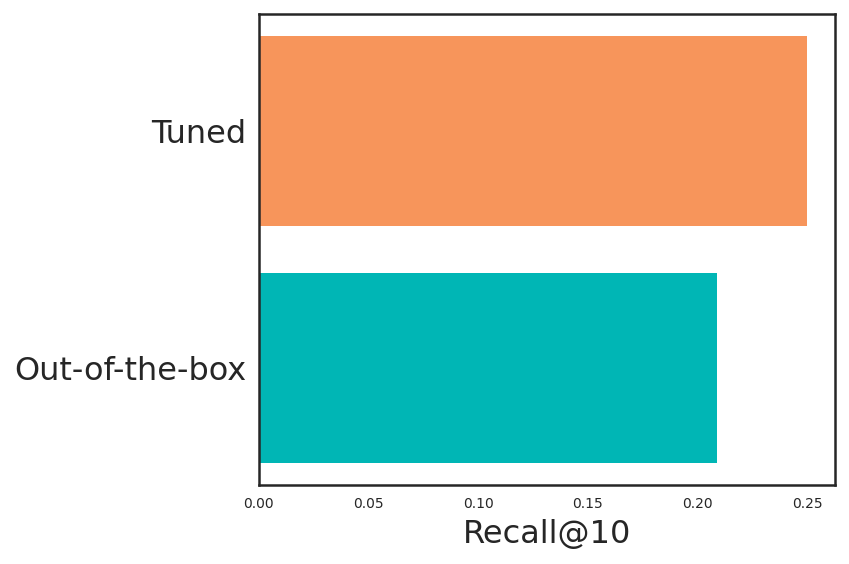

In [43]:
plt.style.use("seaborn-white")

fig = plt.figure()

plt.barh([0,1], width=[ootb_score, tuned_score], color=['#00b6b5', '#f7955b'])
plt.yticks([0,1], ["Out-of-the-box", "Tuned"], fontsize=16)
plt.xlabel("Recall@10", fontsize=16);

plt.tight_layout()

Excellent. Hyperparameter optimization provided us with product embeddings that perform more than 20% better than the out-of-the-box embeddings in this simple recommendation system. 


**If this documentation includes code, including but not limited to, code examples, Cloudera makes this available to you under the terms of the Apache License, Version 2.0, including any required notices. A copy of the Apache License Version 2.0 can be found here.**